<a href="https://colab.research.google.com/github/Carlos-39/Talleres-RN/blob/main/Taller3_RedesNeuronales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Taller 3 - Redes Neuronales

##Integrantes:
- Carlos Daniel Corrales Arango (2122878)
- Jose Manuel Palma (2125182)

### Contenido del Notebook:


## Cargar dataset y analisis inicial

El dataset de la acción que se decidio tomar para su analisis e implementacion de preddicion a partir de las redes neuronales fue el archivo aa.us.txt tomado de https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs?select=Stocks

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Cargar archivo
df = pd.read_csv("aa.us.txt")

# Mostrar las primeras filas
print(df.head())
print(df.shape) # N de registros

         Date    Open    High     Low   Close  Volume  OpenInt
0  1970-01-02  2.2972  2.3178  2.2972  2.2972   26437        0
1  1970-01-05  2.2972  2.2972  2.2544  2.2759   29887        0
2  1970-01-06  2.2759  2.2759  2.2342  2.2342  106900        0
3  1970-01-07  2.2342  2.2342  2.2342  2.2342   85061        0
4  1970-01-08  2.2342  2.2342  2.2139  2.2139   66669        0
(12074, 7)


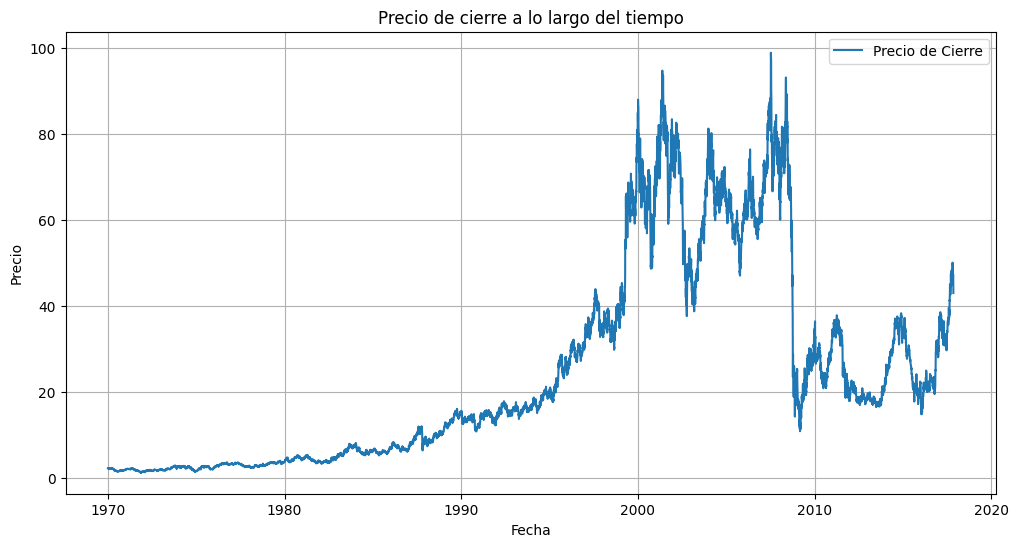

In [ ]:
# Convertir columna 'Date' a datetime
df["Date"] = pd.to_datetime(df["Date"])

# Precio de cierre (Close) a lo largo del tiempo
plt.figure(figsize=(12, 6))
plt.plot(df["Date"], df["Close"], label="Precio de Cierre")
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.title("Precio de cierre a lo largo del tiempo")
plt.legend()
plt.grid(True)
plt.show()

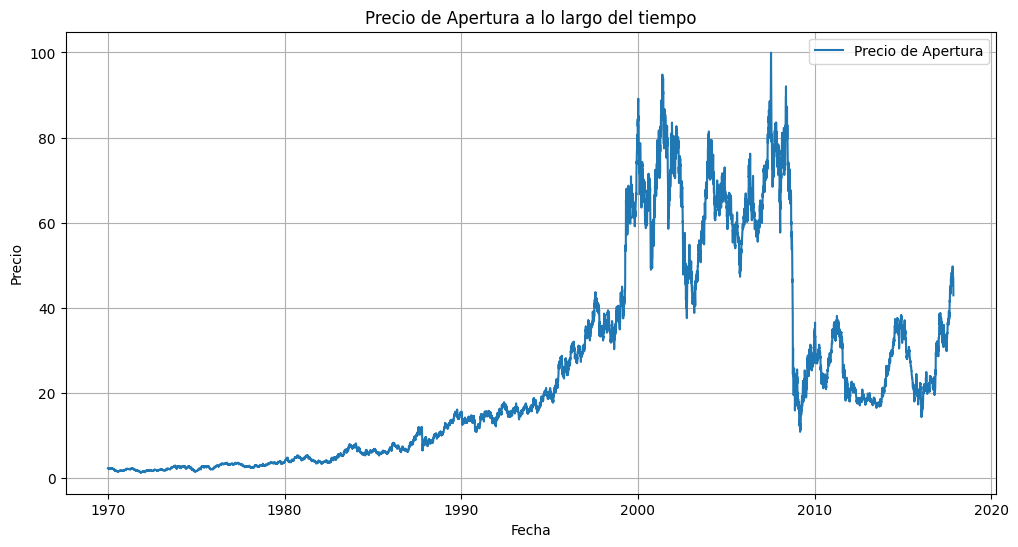

In [ ]:
# Precio de apertura (Open) a lo largo del tiempo
plt.figure(figsize=(12, 6))
plt.plot(df["Date"], df["Open"], label="Precio de Apertura")
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.title("Precio de Apertura a lo largo del tiempo")
plt.legend()
plt.grid(True)
plt.show()

## Punto 1

Cada archivo contiene para cada acción en una fecha (Date) dada:
- Open: Precio de apertura del día
- Close: Precio de cierre del día
- High: Precio más alto de la acción en la fecha dada
- Low: Precio más bajo de la acción en la fecha dada
- Volume: número total de acciones negociadas de un valor/precio concreto
- OpenInt: cantidad de acciones disponibles para la venta

### A. Graficar el valor promedio de la acción

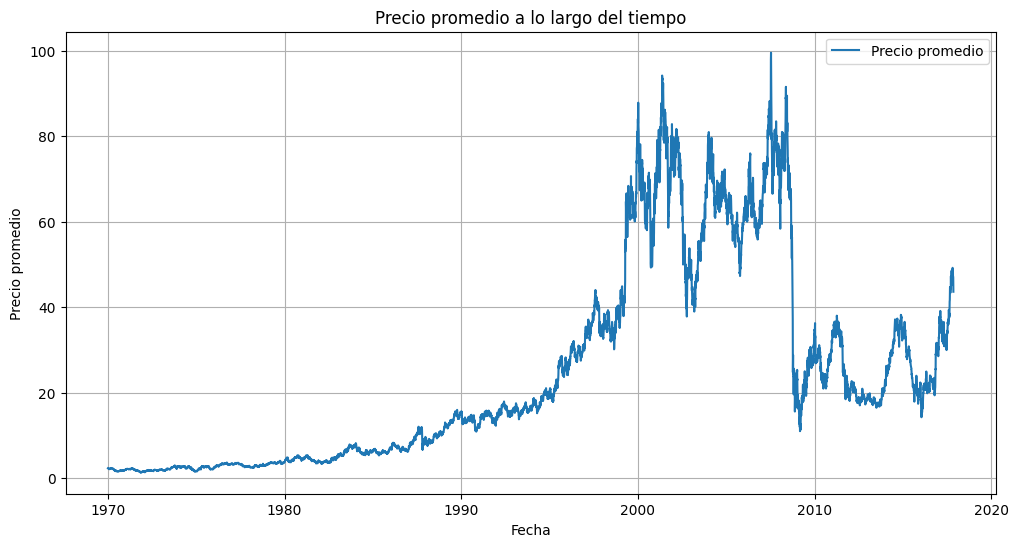

In [ ]:
# Valor promedio de la accion
df["Average"] = (df["High"] + df["Low"]) / 2

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(df["Date"], df["Average"], label="Precio promedio")
plt.xlabel("Fecha")
plt.ylabel("Precio promedio")
plt.title("Precio promedio a lo largo del tiempo")
plt.legend()
plt.grid(True)
plt.show()

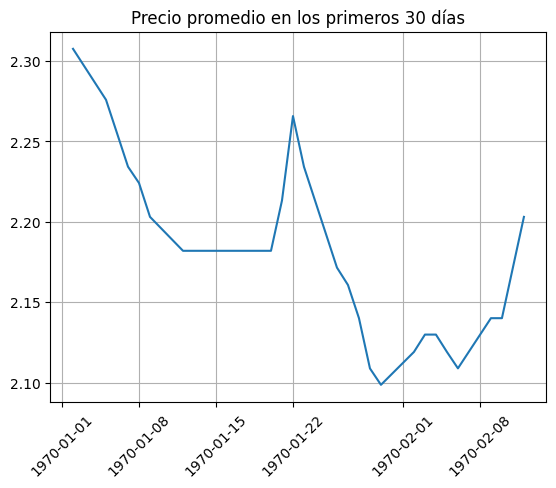

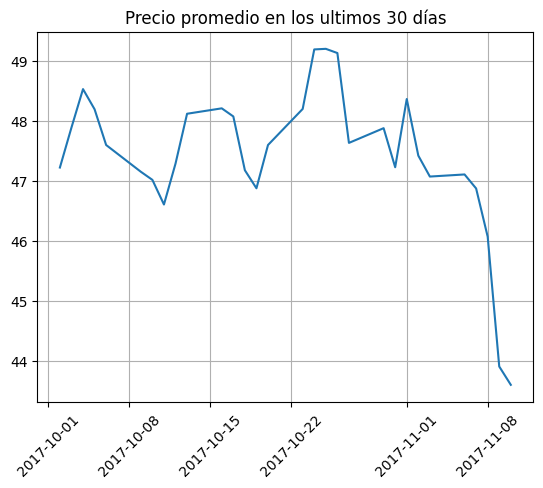

In [ ]:
# Zoom a ciertos periodos

# Primeros 30 dias
plt.plot(df["Date"][:30], df["Average"][:30])
plt.xticks(rotation=45)
plt.title("Precio promedio en los primeros 30 días")
plt.grid(True)
plt.show()

# Ultimos 30 dias
plt.plot(df["Date"].iloc[-30:], df["Average"].iloc[-30:])
plt.xticks(rotation=45)
plt.title("Precio promedio en los ultimos 30 días")
plt.grid(True)
plt.show()

- Como ya se calculo el promedio de las acciones en el tiempo, se va a trabajar a partir de estos valores, primero por un tema de simplicidad y segundo por el tema de que en la normalización de los datos se pide explicitamente "cree ventanas de tiempo de n días correspondientes al valor
promedio de la acción en el tiempo". Se podria usar las variables que ofrece el dataset (Open, High, Low, Close, Volume, OpenInt) y esto puede mejorar la predicción del modelo pero a la vez si no se entrena correctamente puede tener mas riesgo de sobreajuste.

In [ ]:
# Se convierte en un array de NumPy para poder trabajar facilmente con los datos
average = df["Average"].values

# Se le agrega una dimensión adicional para que cada valor se trate como una "feature" al usar LSTM
average = average[..., np.newaxis]

### B. Dividir los datos

Para este taller se cuenta con un total de 12074 registros, por lo tanto, se tomo la desición de separar los datos en los siguientes porcentajes:

- Entrenamiento: 60% (aproximadamente 7244 muestras).
- Validación: 20% (aproximadamente 2415 muestras).
- Prueba: 20% (aproximadamente 2415 muestras).

Al trabajar con datos de series temporales, es importante utilizar datos de validación y prueba que sean más recientes que los datos de entrenamiento, porque está intentando predecir el futuro dado el pasado, no lo inverso, y sus divisiones de validación/prueba deben reflejar eso.

In [ ]:
num_train_samples = int(0.6 * len(average))
num_val_samples = int(0.2 * len(average))
num_test_samples = len(average) - num_train_samples - num_val_samples

print("Entrenamiento:", num_train_samples)
print("Validación:", num_val_samples)
print("Prueba:", num_test_samples)

Entrenamiento: 7244
Validación: 2414
Prueba: 2416


### C. Normalización de los datos

- Se normalizan los datos usando la media y desviación estándar del conjunto de entrenamiento, con el fin de que todos los valores queden centrados en cero y en una escala similar. Esto ayuda al modelo a aprender de forma más eficiente.

- La normalización transforma los datos para que tengan una media cercana a 0 y una desviación estándar cercana a 1. Esto mejora la estabilidad del modelo y acelera el proceso de entrenamiento.

In [ ]:
mean = average[:num_train_samples].mean()
average -= mean

std = average[:num_train_samples].std()
average /= std

- Se generan ventanas de tiempo de 20 días consecutivos (`n = 20`) que serán usados como entrada para predecir el valor del día siguiente (`delay = 1`).
- ¿Por qué n = 20?: fue elegido de manera arbitraria, se llegó a un consenso de que 20 días dan 4 semanas de de datos (entendiendo que el mercado abre 5 días por semana).
- ¿Por qué delay = 1?: en este dataset, cada fila representa un día. Por lo tanto, delay = 1 significa que se está prediciendo el valor promedio de la acción 24 horas después de la última fecha en la ventana.

In [ ]:
from tensorflow import keras

n = 20  # Número de días para cada ventana
sampling_rate = 1  # 1 por día
sequence_length = n  # ventana de n días
delay = 1  # predecir el día siguiente
batch_size = 32

train_dataset = keras.utils.timeseries_dataset_from_array(
    data=average[:-delay],
    targets=average[delay:],
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=batch_size,
    shuffle=True,
    start_index=0,
    end_index=num_train_samples,
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    data=average[:-delay],
    targets=average[delay:],
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=batch_size,
    shuffle=True,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples,
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    data=average[:-delay],
    targets=average[delay:],
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=batch_size,
    shuffle=True,
    start_index=num_train_samples + num_val_samples,
)

- Se inspecciona un lote del conjunto de entrenamiento para verificar la forma de los datos de entrada (ventanas) y sus respectivos valores objetivo.

In [ ]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (32, 20, 1)
targets shape: (32, 1)


## Punto 2

Acá se entrena un modelo LSTM que permita la predicción del valor promedio de
la acción seleccionada en el punto 1, 24 horas después del momento actual.

### A. Entrenamiento de la red neuronal LSTM con diferentes valores

Se entrenarán varios modelos LSTM con diferentes configuraciones para evaluar su rendimiento en la tarea de predecir el valor promedio de la acción un día después (24 horas).

Los parámetros a variar serán:
- Número de neuronas LSTM (units)
- Número de epochs (epochs)
- Tamaño de batch (batch_size)
- Uso de regularización con recurrent_dropout

In [ ]:
from tensorflow.keras import layers, models, callbacks

def entrenar_modelo_lstm(units, epochs, batch_size, use_dropout=False):
    # Definir arquitectura
    model = models.Sequential()
    if use_dropout:
        model.add(layers.LSTM(units, recurrent_dropout=0.2, input_shape=(sequence_length, 1)))
    else:
        model.add(layers.LSTM(units, input_shape=(sequence_length, 1)))

    model.add(layers.Dense(1))  # Capa de salida

    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

    # Entrenar
    history = model.fit(
        train_dataset,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=val_dataset,
        verbose=1
    )

    # Evaluar en test
    test_mae = model.evaluate(test_dataset)[1]

    return model, history, test_mae

### B. Visualización de resultados

Se grafican las curvas de pérdida (MAE) para entrenamiento y validación, así como las predicciones frente a los valores reales de test para cada modelo.

In [ ]:
def graficar_perdidas(history, title="MAE del modelo"):
    loss = history.history["mae"]
    val_loss = history.history["val_mae"]
    epochs_range = range(1, len(loss) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs_range, loss, "bo-", label="Entrenamiento MAE")
    plt.plot(epochs_range, val_loss, "ro-", label="Validación MAE")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("MAE")
    plt.legend()
    plt.grid(True)
    plt.show()

def graficar_predicciones(modelo, dataset, muestras=40, title="Predicción vs Valor real"):
    predictions = modelo.predict(dataset)
    y_true = np.concatenate([y for _, y in dataset], axis=0)

    plt.figure(figsize=(10, 5))
    plt.plot(y_true[:muestras], label="Valores reales", marker="o")
    plt.plot(predictions[:muestras], label="Predicciones", marker="x")
    plt.title(title)
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

### Ejecución de las configuraciones


 Entrenando modelo 1 con configuración: {'units': 16, 'epochs': 15, 'batch_size': 32, 'use_dropout': True}
Epoch 1/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - loss: 0.5066 - mae: 0.4347 - val_loss: 8.5666 - val_mae: 2.6422
Epoch 2/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0156 - mae: 0.0819 - val_loss: 6.5681 - val_mae: 2.2712
Epoch 3/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0105 - mae: 0.0642 - val_loss: 6.7451 - val_mae: 2.3093
Epoch 4/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0092 - mae: 0.0584 - val_loss: 5.9980 - val_mae: 2.1581
Epoch 5/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0080 - mae: 0.0544 - val_loss: 5.7619 - val_mae: 2.1084
Epoch 6/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0080 - mae: 0.0537 - val_loss: 5.6361 - val_mae: 2.0851
Epoch 7/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0082 - mae: 0.0538 - val_loss: 5.6061 - val_mae: 2.0792
Epoch 8/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss

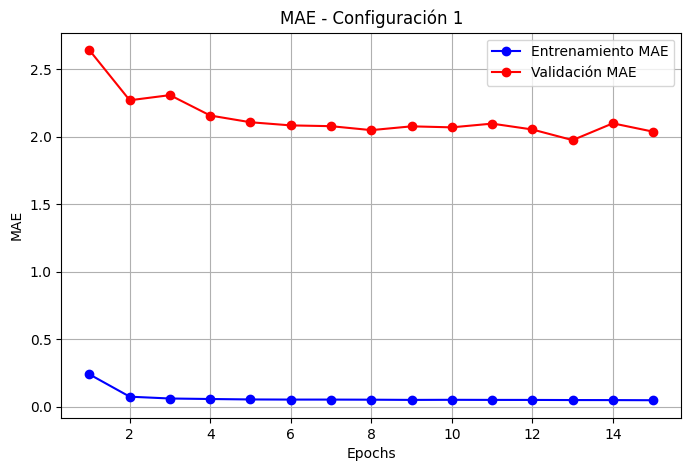

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


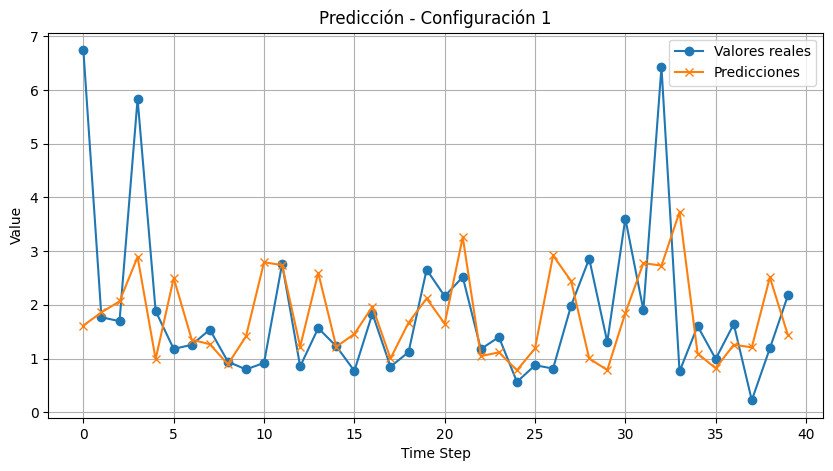

Test MAE para configuración 1: 0.3220

 Entrenando modelo 2 con configuración: {'units': 32, 'epochs': 20, 'batch_size': 64, 'use_dropout': True}
Epoch 1/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.1665 - mae: 0.2207 - val_loss: 5.5652 - val_mae: 2.0881
Epoch 2/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0097 - mae: 0.0614 - val_loss: 4.8679 - val_mae: 1.9300
Epoch 3/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0086 - mae: 0.0563 - val_loss: 4.5239 - val_mae: 1.8500
Epoch 4/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.0086 - mae: 0.0559 - val_loss: 4.9172 - val_mae: 1.9471
Epoch 5/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0076 - mae: 0.0526 - val_loss: 4.6047 - val_mae: 1.8693
Epoch 6/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0081 - mae: 0.0538 - val_loss: 5.1999 - val_mae: 2.0099
Epoch 7/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0077 - mae: 0.0532 - val_loss: 5.1587 - val_mae: 1.9954
Epoch 8/20
226/226 ━━

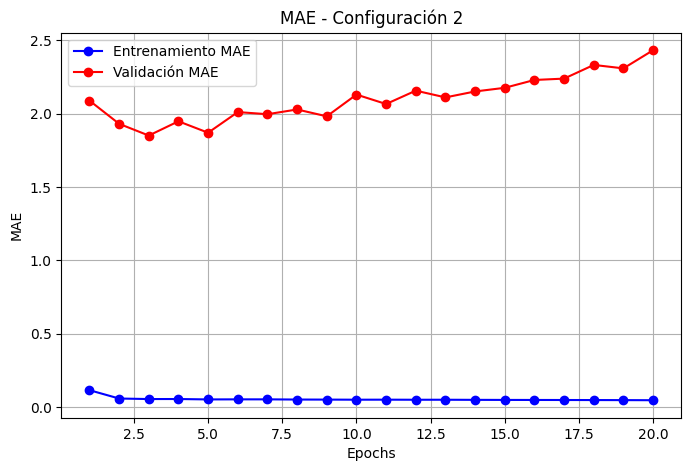

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


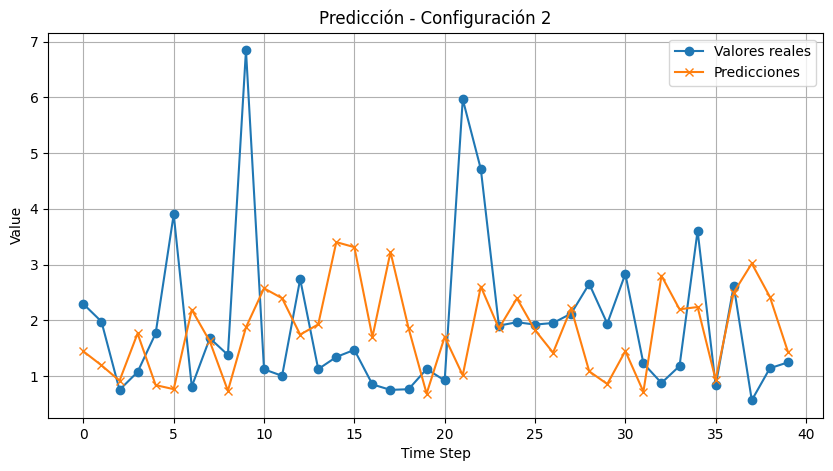

Test MAE para configuración 2: 0.3157

 Entrenando modelo 3 con configuración: {'units': 64, 'epochs': 25, 'batch_size': 128, 'use_dropout': False}
Epoch 1/25
226/226 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0915 - mae: 0.1405 - val_loss: 5.8519 - val_mae: 2.1388
Epoch 2/25
226/226 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0096 - mae: 0.0603 - val_loss: 6.7944 - val_mae: 2.3134
Epoch 3/25
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0078 - mae: 0.0557 - val_loss: 6.7676 - val_mae: 2.2862
Epoch 4/25
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0070 - mae: 0.0549 - val_loss: 7.7791 - val_mae: 2.4680
Epoch 5/25
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0065 - mae: 0.0511 - val_loss: 8.5259 - val_mae: 2.5841
Epoch 6/25
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0065 - mae: 0.0516 - val_loss: 10.0294 - val_mae: 2.8207
Epoch 7/25
226/226 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0053 - mae: 0.0492 - val_loss: 11.3607 - val_mae: 3.0034
Epoch 8/25
226/22

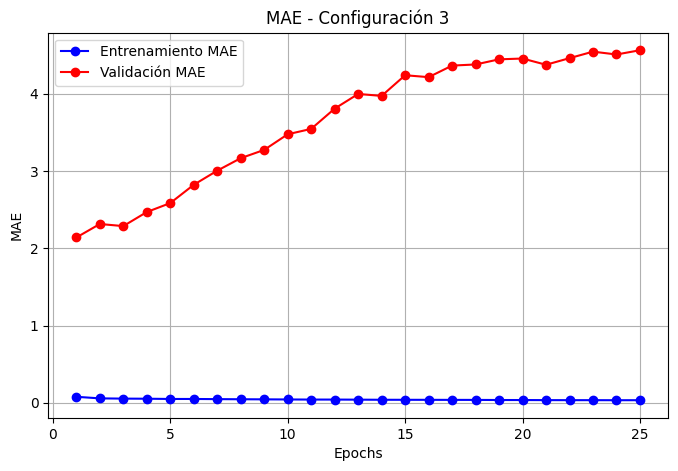

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


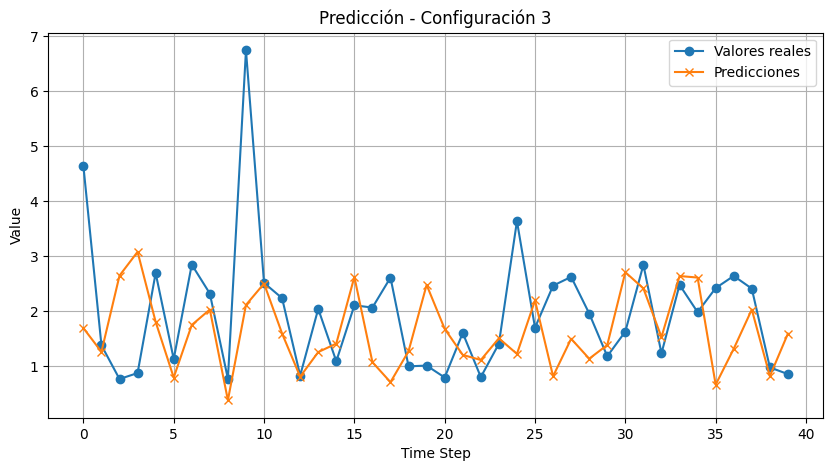

Test MAE para configuración 3: 0.3481


In [ ]:
# Posibles configuraciones
configuraciones_lstm = [
    {"units": 16, "epochs": 15, "batch_size": 32, "use_dropout": True},
    {"units": 32, "epochs": 20, "batch_size": 64, "use_dropout": True},
    {"units": 64, "epochs": 25, "batch_size": 128, "use_dropout": False}
]

resultados_lstm = []

for i, config in enumerate(configuraciones_lstm):
    print(f"\n Entrenando modelo {i+1} con configuración: {config}")
    model, history, test_mae = entrenar_modelo_lstm(**config)
    resultados_lstm.append((config, history, test_mae))

    graficar_perdidas(history, title=f"MAE - Configuración {i+1}")
    graficar_predicciones(model, test_dataset, title=f"Predicción - Configuración {i+1}")
    print(f"Test MAE para configuración {i+1}: {test_mae:.4f}")

### C. Configuración que genera mejores resultados

Después de entrenar y evaluar las tres configuraciones de la arquitectura LSTM, se pudo concluir que la segunda configuración (32 unidades LSTM, 20 epochs, batch size de 64 y uso de dropout) fue la que generó un mejor resultado global, con un MAE de 0.3157, el más bajo de las 3 configuraciones.

Aunque las gráficas de pérdida vs iteraciones mostraron un comportamiento que se podría denominar como malo o inestable en la validación (val_mae alto y poco descenso), en las gráficas de predicciones si se pudo ver que los modelos lograron capturar de manera correcta (no perfecta) el patrón general de la serie temporal. Las predicciones siguieron la forma y tendencia de los datos reales de una forma bastante correcta, lo que demuestra que los modelos aprendieron correctamente la dinámica en la que se está. Esto se pudo deber a que en si la bolsa es un mercado muy variable en el tiempo, se es imposible tener el 100% de precisión de que va a ocurrir en el futuro ya que es algo que no se puede controlar de alguna manera, se puede manejar y evidenciar tendencias pero más allá de ese factor, es difícil llegar al 100% de precisión.

Por otro lado, los valores de MAE en entrenamiento fueron muy bajos (< 0.05) en todos los casos, lo cual indica que la red logró ajustar bien el modelo a los datos de entrenamiento. La segunda configuración, al mantener el mejor balance entre baja pérdida en entrenamiento y menor error de prueba, puede considerarse la más eficiente de las tres.

En general, se logró un buen desempeño en la predicción del valor promedio de la acción usando redes LSTM. Aunque las curvas de validación mostraron cierta variabilidad, el bajo MAE de prueba y la observación correcta entre predicciones y valores reales indican que el modelo logró aprender con éxito los patrones temporales.

## Punto 3

Acá se entrena un modelo GRU que permita la predicción del valor promedio de
la acción seleccionada en el punto 1, 24 horas después del momento actual.

### A. Entrenamiento de la red neuronal GRU con diferentes valores

Se entrenarán varios modelos GRU con diferentes configuraciones para evaluar su rendimiento en la tarea de predecir el valor promedio de la acción un día después (24 horas).

Los parámetros a variar serán:
- Número de neuronas GRU (units)
- Número de epochs (epochs)
- Tamaño de batch (batch_size)
- Uso de regularización con recurrent_dropout

In [ ]:
from tensorflow.keras import layers, models, callbacks

def entrenar_modelo_gru(units, epochs, batch_size, use_dropout=False):
    # Definir arquitectura
    model = models.Sequential()
    if use_dropout:
        model.add(layers.GRU(units, recurrent_dropout=0.2, input_shape=(sequence_length, 1)))
    else:
        model.add(layers.GRU(units, input_shape=(sequence_length, 1)))

    model.add(layers.Dense(1))  # Capa de salida

    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

    # Entrenar
    history = model.fit(
        train_dataset,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=val_dataset,
        verbose=1
    )

    # Evaluar en test
    test_mae = model.evaluate(test_dataset)[1]

    return model, history, test_mae

### B. Visualización de resultados

Se grafican las curvas de pérdida (MAE) para entrenamiento y validación, así como las predicciones frente a los valores reales de test para cada modelo.

In [ ]:
def graficar_perdidas(history, title="MAE del modelo"):
    loss = history.history["mae"]
    val_loss = history.history["val_mae"]
    epochs_range = range(1, len(loss) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs_range, loss, "bo-", label="Entrenamiento MAE")
    plt.plot(epochs_range, val_loss, "ro-", label="Validación MAE")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("MAE")
    plt.legend()
    plt.grid(True)
    plt.show()

def graficar_predicciones(modelo, dataset, muestras=40, title="Predicción vs Valor real"):
    predictions = modelo.predict(dataset)
    y_true = np.concatenate([y for _, y in dataset], axis=0)

    plt.figure(figsize=(10, 5))
    plt.plot(y_true[:muestras], label="Valores reales", marker="o")
    plt.plot(predictions[:muestras], label="Predicciones", marker="x")
    plt.title(title)
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

### Ejecución de las configuraciones


 Entrenando modelo 1 con configuración: {'units': 16, 'epochs': 15, 'batch_size': 32, 'use_dropout': True}
Epoch 1/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.2525 - mae: 0.2961 - val_loss: 6.5533 - val_mae: 2.2982
Epoch 2/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0120 - mae: 0.0664 - val_loss: 5.7584 - val_mae: 2.1199
Epoch 3/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0098 - mae: 0.0600 - val_loss: 6.0183 - val_mae: 2.1641
Epoch 4/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0091 - mae: 0.0578 - val_loss: 5.6628 - val_mae: 2.0777
Epoch 5/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0087 - mae: 0.0565 - val_loss: 5.5337 - val_mae: 2.0504
Epoch 6/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0087 - mae: 0.0562 - val_loss: 5.8715 - val_mae: 2.1308
Epoch 7/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0084 - mae: 0.0550 - val_loss: 5.2646 - val_mae: 2.0039
Epoch 8/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss

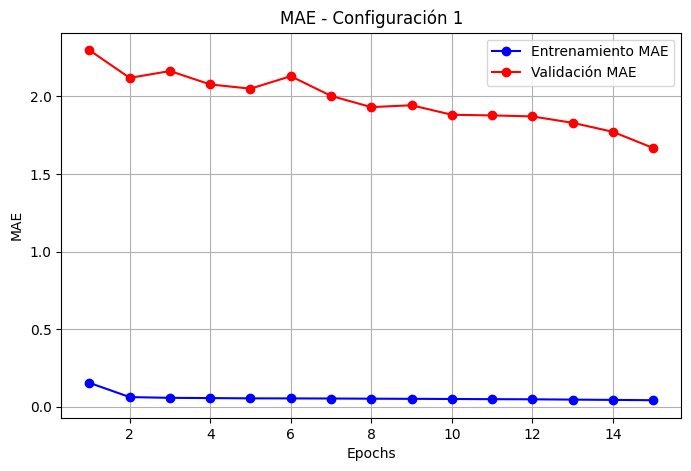

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


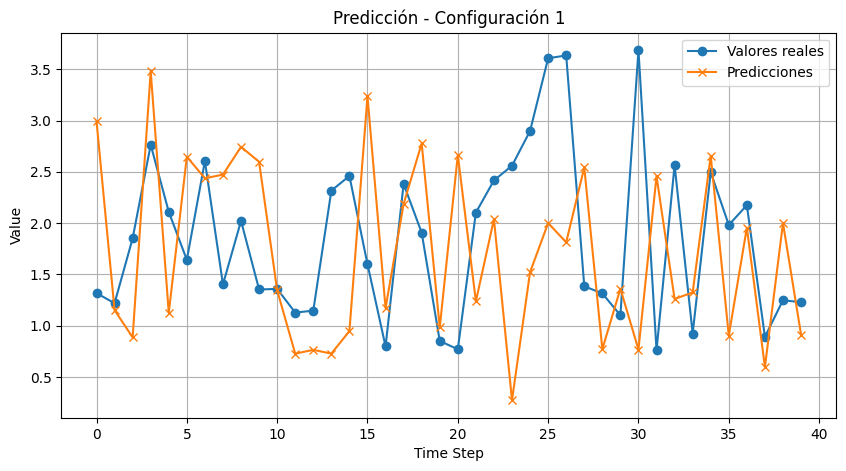

Test MAE para configuración 1: 0.2335

 Entrenando modelo 2 con configuración: {'units': 32, 'epochs': 20, 'batch_size': 64, 'use_dropout': True}
Epoch 1/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - loss: 0.1609 - mae: 0.2227 - val_loss: 4.6717 - val_mae: 1.9052
Epoch 2/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.0106 - mae: 0.0630 - val_loss: 4.4706 - val_mae: 1.8308
Epoch 3/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0095 - mae: 0.0596 - val_loss: 4.8624 - val_mae: 1.8941
Epoch 4/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0088 - mae: 0.0571 - val_loss: 5.8130 - val_mae: 2.0897
Epoch 5/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0087 - mae: 0.0563 - val_loss: 6.1524 - val_mae: 2.1558
Epoch 6/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0086 - mae: 0.0558 - val_loss: 6.1853 - val_mae: 2.1586
Epoch 7/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0079 - mae: 0.0546 - val_loss: 6.4038 - val_mae: 2.2090
Epoch 8/20
226/226 ━

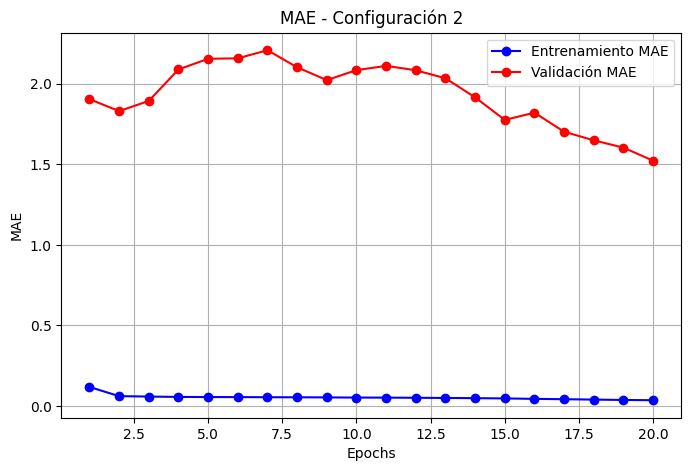

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


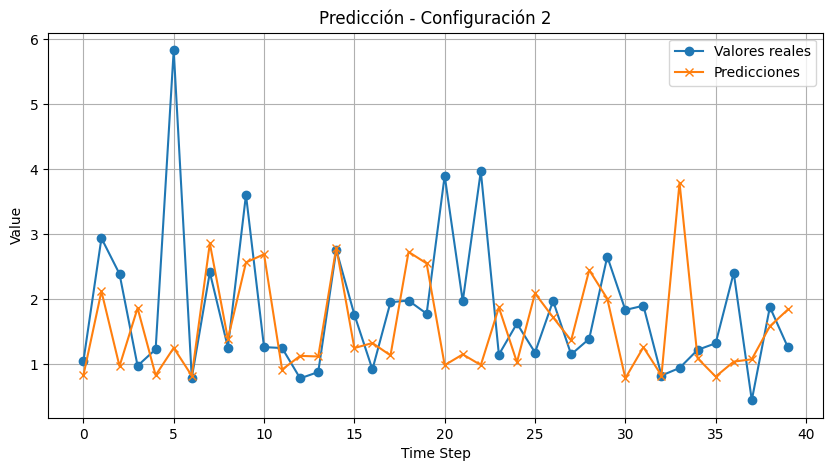

Test MAE para configuración 2: 0.1742

 Entrenando modelo 3 con configuración: {'units': 64, 'epochs': 25, 'batch_size': 128, 'use_dropout': False}
Epoch 1/25
226/226 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 0.1874 - mae: 0.2029 - val_loss: 2.7865 - val_mae: 1.4241
Epoch 2/25
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0099 - mae: 0.0600 - val_loss: 3.5757 - val_mae: 1.6478
Epoch 3/25
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0091 - mae: 0.0581 - val_loss: 3.5350 - val_mae: 1.6176
Epoch 4/25
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0086 - mae: 0.0571 - val_loss: 4.4305 - val_mae: 1.8332
Epoch 5/25
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0077 - mae: 0.0551 - val_loss: 4.1154 - val_mae: 1.7316
Epoch 6/25
226/226 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0081 - mae: 0.0564 - val_loss: 5.2914 - val_mae: 1.9937
Epoch 7/25
226/226 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0068 - mae: 0.0539 - val_loss: 6.1282 - val_mae: 2.1653
Epoch 8/25
226/226 

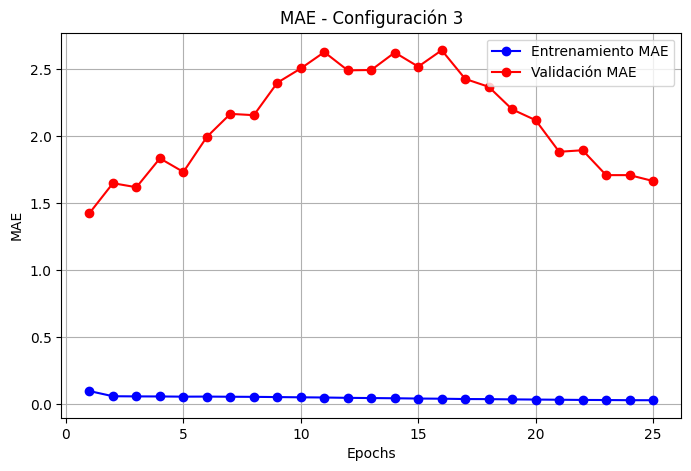

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


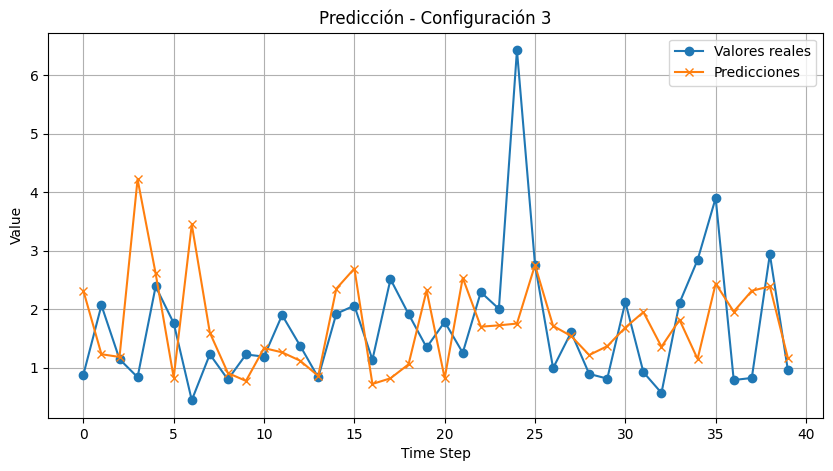

Test MAE para configuración 3: 0.1878


In [ ]:
# Posibles configuraciones
configuraciones_gru = [
    {"units": 16, "epochs": 15, "batch_size": 32, "use_dropout": True},
    {"units": 32, "epochs": 20, "batch_size": 64, "use_dropout": True},
    {"units": 64, "epochs": 25, "batch_size": 128, "use_dropout": False}
]

resultados_gru = []

for i, config in enumerate(configuraciones_gru):
    print(f"\n Entrenando modelo {i+1} con configuración: {config}")
    model, history, test_mae = entrenar_modelo_gru(**config)
    resultados_gru.append((config, history, test_mae))

    graficar_perdidas(history, title=f"MAE - Configuración {i+1}")
    graficar_predicciones(model, test_dataset, title=f"Predicción - Configuración {i+1}")
    print(f"Test MAE para configuración {i+1}: {test_mae:.4f}")

### C. Configuración que genera mejores resultados

Al igual que en el punto 2 del taller usando redes LSTM, ahora también se probaron tres configuraciones de la arquitectura GRU, y se pudo concluir que la segunda configuración (32 unidades LSTM, 20 epochs, batch size de 64 y uso de dropout) fue la que generó un mejor resultado global de igual manera que en las redes LSTM, con un MAE de 0.1742, el más bajo de las 3 configuraciones.

En las gráficas de pérdida vs iteraciones se observó un patrón relativamente estable en las tres configuraciones, con un bajo error en entrenamiento (debido a la naturaleza del modelo) y un error mayor en validación, aunque mostrando mejora progresiva especialmente en la configuración 2. Si bien los valores de validación fueron altos, las gráficas de predicciones mostraron un buen alineamiento entre los valores reales y los predichos, lo cual sugiere que el modelo fue capaz de capturar la tendencia general de la serie temporal.

La arquitectura GRU mostró un rendimiento adecuado en la tarea de predicción del valor promedio de una acción 24 horas después. Aunque las curvas de pérdida no evidenciaron una mejora drástica durante las iteraciones, el comportamiento del modelo en las predicciones reales fue correcto. Además, cabe recalcar que las redes GRU tuvieron un mejor rendimiento general en comparación a las redes LSTM, con un menor valor de MAE de entrenamiento en todas sus configuraciones y observando las predicciones se puede concluir que tiene más similitud con los valores reales en la red GRU que la red LSTM, esto se podría deber a quizás que la red GRU cuenta con menos parámetros con los que entrenar y su cálculo es más rápido que una celda LSTM.

